In [57]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math

def load_data(file):
    return sio.loadmat(file)


def single_autocorrelation(scan):
    result = np.correlate(scan, scan, mode='full')
    autocorr = result[result.size // 2:]
    return autocorr / float(autocorr.max())


def my_single_autocorrelation(scan):
    l = len(scan)
    a = np.zeros(l)
    for k in range(0, l):
        offset = l - k
        a[k] = scan[0: offset - 1].dot(scan[k: l - 1])
        a[k] = a[k] / float(l)
    return a / float(a.max())


def calculate_autocorr(scans):
    a = np.zeros(shape=(scans.shape[0], scans.shape[1]))
    for i in range(0, scans.shape[0]):
        a[i] = my_single_autocorrelation(scans[i, :])
    return a

def calculate_apriori(class1, class2):
    total = class1 + class2
    return class1 / total, class2/total

In [58]:
data = load_data("data/trainecg.mat")

diseased = data["diseased"]
healthy = data["healthy"]

num_dis = diseased.shape[0]
num_health = healthy.shape[0]
num_points = diseased.shape[1]

In [59]:
auto_dis = calculate_autocorr(diseased)
auto_hea = calculate_autocorr(healthy)



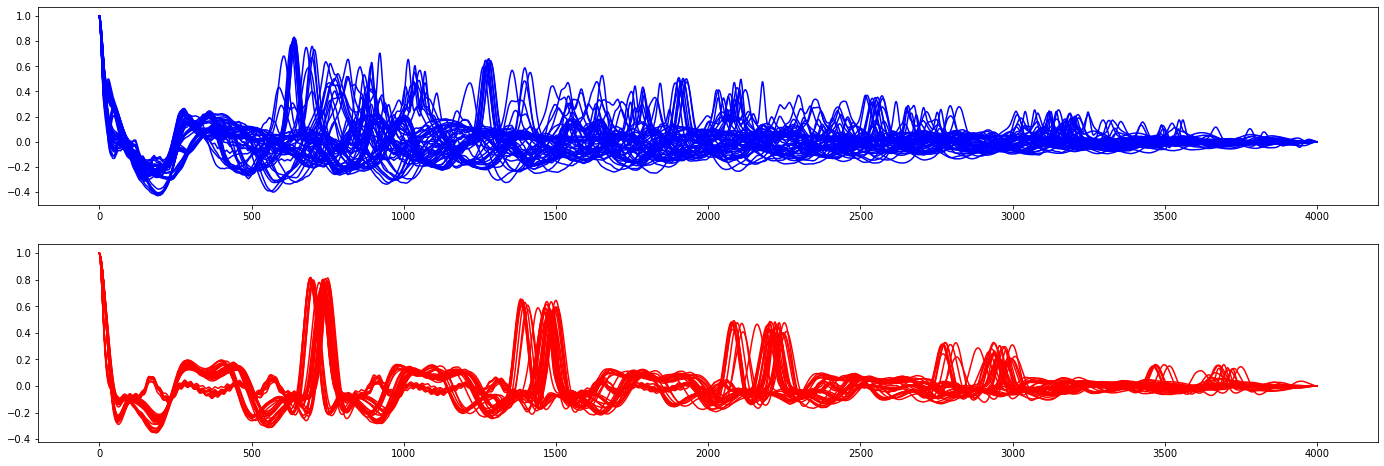

In [60]:
x_axis = range(0, 4000)

fig, axes = plt.subplots(2, 1, figsize=(24, 8))

for i in range(num_health):
    axes[0].plot(x_axis, auto_hea[i], '-' + 'b')

for i in range(num_dis):
    axes[1].plot(x_axis, auto_dis[i], '-' + 'r')

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2.,
        0., 2., 0., 1., 1., 1., 0., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1.,
        1., 2., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1.,
        2., 0., 0., 2., 2., 0., 0., 0., 1., 1., 0., 1., 1., 0., 2.]),
 array([-0.06698045, -0.06431181, -0.06164316, -0.05897452, -0.05630588,
        -0.05363723, -0.05096859, -0.04829994, -0.0456313 , -0.04296265,
        -0.04029401, -0.03762536, -0.03495672, -0.03228808, -0.02961943,
        -0.02695079, -0.02428214, -0.0216135 , -0.01894485, -0.01627621,
        -0.01360757, -0.01093892, -0.00827028, -0.00560163, -0.00293299,
        -0.00026434,  0.0024043 ,  0.00507294,  0.00774159,  0.01041023,
         0.01307888,  0.01574752,  0.01841617,  0.02108481,  0.02375345,
         0.0264221 ,  0.02909074,  0.03

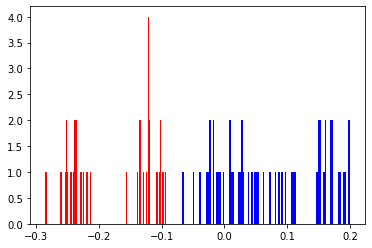

In [61]:
k=66
plt.hist(auto_dis[:,k], color = "red", bins=100)
plt.hist(auto_hea[:,k], color="blue", bins=100)

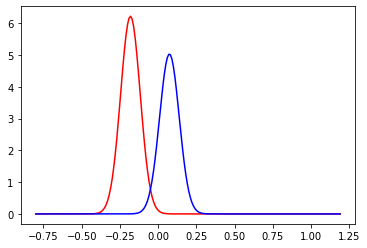

In [62]:
dis_mean = np.mean(auto_dis[:,k])
hea_mean = np.mean(auto_hea[:,k])

dis_std = np.std(auto_dis[:,k])
hea_std = np.std(auto_hea[:,k])

P_H, P_D = calculate_apriori(num_health, num_dis)


ProbR_diseased = lambda r: (1/(dis_std*math.sqrt(2*math.pi)))*math.exp((-(r-dis_mean)**2)/(2*dis_std**2))
ProbR_healthy = lambda r: (1/(hea_std*math.sqrt(2*math.pi)))*math.exp(-(r-hea_mean)**2/(2*dis_std**2))

points = np.arange(-0.8,1.2,0.01)
plt.plot(points, [ProbR_diseased(x) for x in points], '-' + 'r')
plt.plot(points,  [ProbR_healthy(x) for x in points], '-' + 'b')



In [63]:
Prob_diseased = lambda r: (ProbR_diseased(r) * P_D)/(ProbR_diseased(r)*P_D + ProbR_healthy(r)*P_H)
Prob_healthy = lambda r: (ProbR_healthy(r) * P_H)/(ProbR_diseased(r)*P_D + ProbR_healthy(r)*P_H)


ProbR_diseased(auto_dis[0,k])
ProbR_healthy(auto_dis[0,k])

0.11620028331847995

In [64]:
sum = 0
for i in range(0,num_dis):
    if ProbR_diseased(auto_dis[i,k]) > ProbR_healthy(auto_dis[i,k]):
        sum += 1

print("Accuracy: " + str((sum/num_dis) * 100) + "%")


Accuracy: 100.0%


In [65]:
sum = 0
for i in range(0,num_health):
    if ProbR_diseased(auto_hea[i,k]) < ProbR_healthy(auto_hea[i,k]):
        sum += 1

print("Accuracy: " + str((sum/num_health) * 100) + "%")



Accuracy: 96.29629629629629%


In [66]:
test_data = load_data("data/trainecg.mat")
test_diseased = data["diseased"]
test_healthy = data["healthy"]

num_test_dis = test_diseased.shape[0]
num_test_health = test_healthy.shape[0]
num_points = num_test_dis+num_test_health

test_dis_autocorrelation = calculate_autocorr(test_diseased)
test_hea_autocorrelation = calculate_autocorr(test_healthy)

sum = 0
for i in range(0,num_test_dis):
    if ProbR_diseased(test_dis_autocorrelation[i,k]) > ProbR_diseased(test_dis_autocorrelation[i,k]):
        sum += 1
        
for i in range(0,num_test_health):
    if ProbR_healthy(test_hea_autocorrelation[i,k]) > ProbR_healthy(test_hea_autocorrelation[i,k]):
        sum += 1


print("Accuracy: " + str((sum/num_points) * 100) + "%")

Accuracy: 0.0%
